In [246]:
import numpy as np
import matplotlib.pyplot as plt


class sm_transport:
    
    """
    Generate the Stanton and Murillo transport coefficients.
    
    References
    ----------
    .. [1] Stanton, Liam G., and Michael S. Murillo. 
    "Ionic transport in high-energy-density matter." 
    Physical Review E 93.4 (2016): 043203.

    """

    def __init__(self, Am, mass_density, T, Z, units_out='star'):
        """
        Initialize all parameters to be shared across methods.

        Parameters
        ----------
        Am : float or arrary_like
            Atomic mass of element (or isotope) in units of grams [g].
            
        mass_density : float or array_like
            Range of mass densities in units of grams per 
            cubic centimeter [g/cc]. 
        T : float or array_like
            Temperature range in units of elevtron-volts [eV]
            
        Z : int or arrray_like
            Atomic number for each element
            
        units_out : str
            Unit system for resulting transport coefficient.
            Default: dimensionless "star" units.
        """
        
        # Check type of input and deal with float cases
        self.mi = Am
        if str(type(self.mi)) != "<class 'numpy.ndarray'>":
            self.mi = np.array([Am])

        self.Z = Z
        if str(type(self.Z)) != "<class 'numpy.ndarray'>":
            self.Z = np.array([Z])
            
        try:
            self.num_density = np.tile(mass_density, len(Am))/np.repeat(Am, len(mass_density))            
            self.num_density = np.reshape(self.num_density, (len(Am) ,len(mass_density)))
        except:
            self.num_density = np.array([mass_density])/Am

        self.T = T
        if str(type(self.T)) != "<class 'numpy.ndarray'>":
            self.T = np.array([T])

        # Class wide parameter definition in cgs units
        self.e_squared = 1.4399644800e-7 # [ev cm]
        self.hbar = 6.5822958e-16 # reduced Planck's constant [eV*s]
        self.me = 9.1095e-28 # mass of electron [g]
        self.units_out = units_out
        
    def TF_Zbar(self, Z, ni):

        """
        Thomas Fermi Zbar model.
        
        Parameters
        ----------
        Z : int
            Atomic number.
            
        ni : float
            Number density in units particles per 
            cubic centimeter [N/cc].
      
        References
        ----------
        .. [2] Finite Temperature Thomas Fermi Charge State using 
        R.M. More, "Pressure Ionization, Resonances, and the
        Continuity of Bound and Free States", Adv. in Atomic 
        Mol. Phys., Vol. 21, p. 332 (Table IV).
        """
        
        alpha = 14.3139
        beta = 0.6624
        a1 = 0.003323
        a2 = 0.9718
        a3 = 9.26148e-5
        a4 = 3.10165
        b0 = -1.7630
        b1 = 1.43175
        b2 = 0.31546
        c1 = -0.366667
        c2 = 0.983333

        convert = ni * 1.6726219e-24
        R = convert/Z
        T0 = self.T/Z**(4./3.)
        Tf = T0/(1 + T0)
        A = a1*T0**a2 + a3*T0**a4
        B = -np.exp(b0 + b1*Tf + b2*Tf**7)
        C = c1*Tf + c2
        Q1 = A*R**B
        Q = (R**C + Q1**C)**(1/C)
        x = alpha*Q**beta
        
        self.Zbar = Z * x/(1 + x + np.sqrt(1 + 2*x))      

    def plasma_params(self, Z, ni, mi):
        """
        Computes the plasma parameters (e.g. ion plasma frequency, ion-sphere radius, 
                                        coupling parameter, etc.).
                                        
        Parameters
        ----------
        Z : int
            Atomic number 
        ni : float
            Number density [1/cc]
        mi : float
            Atomic mass [g]       
        """

        self.TF_Zbar(Z, ni)

        self.ne = self.Zbar * ni # Compute electron number density [1/cm^3]

        self.ai = (4 * np.pi * ni/3)**(-1/3) # Wigner-Seitz radius [cm]
        
        self.gamma = self.Zbar**2 * self.e_squared/(self.ai * self.T) # Coulomb coupling parameter

        self.wp = np.sqrt(4 * np.pi * self.Zbar**2 * ni * self.e_squared/ mi * 1.60218e-12) # Plasma frequency [1/s]

        self.Ef = self.hbar**2/(2 * self.me) * (3 * np.pi**2 * self.ne)**(2/3) * 1.60218e-12 # fermi-energy [ev]

        self.lam_sq = ( self.T**(9/5) + (2/3*self.Ef)**(9/5) )**(5/9) / (4 * np.pi * self.ne * self.e_squared) # [cm]

        self.kappa = self.ai/np.sqrt(self.lam_sq) # inverse screening length # [1]

        self.g  = np.array(self.gamma * np.sqrt( self.kappa**2  + (3*self.gamma)/(1 + 3 * self.gamma) )) # Plasma parameter
        
        
    def Knm(self, g, n, m):
        """
        Computes the plasma parameters (e.g. ion plasma frequency, ion-sphere radius, 
                                        coupling parameter, etc.).
                                        
        Parameters
        ----------
        g : float or array_like
            Plasma parameter (eq. 54 from [1]) 
        n : int
            Subscript for collision intergral Knm (eq. C22 from [1])
        m : int
            Subscript for collision integral Knm (eq. C22 from [1])
            
        Returns
        -------
        Knm : array_like
            Fit to collision integral (eqs. C22-C24 from [1])
        """

        if n and m == 1:
            a = np.array([1.4660, -1.7836, 1.4313, -0.55833, 0.061162])
            b = np.array([0.081033, -0.091336, 0.051760, -0.50026, 0.17044])
            
        if n and m == 2:
            a = np.array([0.85401, -0.22898, -0.60059, 0.80591, -0.30555])
            b = np.array([0.43475, -0.21147, 0.11116, 0.19665, 0.15195])
            
        Knm = np.zeros(len(self.g))
        
        for i in range(len(g)):
            g_arr = np.array([g[i], g[i]**2, g[i]**3, g[i]**4, g[i]**5])
        
            if g[i] < 1:
                Knm[i] = -n/4 * np.math.factorial(m - 1) * np.log( np.dot(a,g_arr) ) 
            else:
                Knm[i] = (b[0] + b[1]*np.log(g[i]) + b[2]*np.log(g[i])**2)/(1 + b[3]*g[i] + b[4]*g[i]**2)

        return Knm

    
    def self_diffusion(self):
        """
        Computes the self-diffusion coefficient using eq. 56 from [1].

        Returns
        -------
        D : float or array_like
            Self-diffusion coefficients for system parameters.
            
        Note
        ----
        The structure in which D is returned is in the form of a 3D array (1D if single value inputs). 
        The first axis corresponds to density, the second is temperature, and the third is atomic number. 
        
        Example
        -------
        Single value input:
        Am = 1.9944235e-23 # g
        rho = 1 # g/cc
        T = 0.5 # eV
        Z = 6
        
        D[0] returns the self-diffusion coefficient for T = 0.5 eV, rho = 1 g/cc, and Z = 6.
             
        Range of inputs:
        Am = np.array([1.6735575e-24, 1.9944235e-23, 4.4803895e-23, 8.4590343e-23]) # g
        rho = np.array([1, 10, 100]) # g/cc
        T = np.array([0.1, 1, 10, 100]) # eV
        Z = np.array([1, 6, 13, 23])
        
        D[0,1,3] returns the self-diffusion coefficient corresponding to the zeroth (python indexing) 
        mass density in your input array (in this 1 g/cc), the first temperature of your 
        T array (T = 1 eV), and the third entry in your Z array (Z = 23 for vanadium).   
        """

        # Single density, single element
        if len(self.num_density.shape) == 1 and len(self.Z) == 1:
            self.plasma_params(self.Z, self.num_density, self.mi)
 
            if self.units_out == 'star':
                D = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1))

            elif self.units_out == 'cgs':
                D = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1)) \
                * self.wp * self.ai**2 
                
            elif self.units_out == 'mks':
                D = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1)) \
                * self.wp * (self.ai/100)**2
                
            else:
                print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs", "mks"')
        
        # Single mass density, multiple elements
        elif len(self.num_density.shape) == 1 and len(self.Z) != 1:
            D = np.zeros([1, len(self.T), len(self.Z)])
            
            for k in range(len(self.Z)):
                self.plasma_params(self.Z[k], self.num_density[k], self.mi[k])

                if self.units_out == 'star':
                    D[0,:,k] = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1))

                elif self.units_out == 'cgs':
                    D[0,:,k] = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1)) \
                    * self.wp * self.ai**2 

                elif self.units_out == 'mks':
                    D[0,:,k] = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1)) \
                    * self.wp * (self.ai/100)**2 

                else:
                    print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs", "mks"')       

        # Multiple mass densities, multiple elements
        else:
            D = np.zeros([self.num_density.shape[1], len(self.T), len(self.Z)])
            
            for k in range(len(self.Z)):
                for i in range(self.num_density.shape[1]):
                    self.plasma_params(self.Z[k], self.num_density[k,i], self.mi[k])

                    if self.units_out == 'star':
                        D[i,:,k] = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1))

                    elif self.units_out == 'cgs':
                        D[i,:,k] = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1))\
                        * self.wp * self.ai**2 
                        
                    elif self.units_out == 'mks':
                        D[i,:,k] = np.sqrt(3*np.pi)/(12 * self.gamma**(5/2) * self.Knm(self.g, 1, 1)) \
                        * self.wp * (self.ai/100)**2 
                        
                    else:
                        print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs", "mks"')            
        return D
    
    def viscocity(self):
        """
        Computes the viscocity coefficient using eq. 75 from [1].

        Returns
        -------
        eta : float or array_like
            Viscocity coefficients for system parameters.
            
        Note
        ----
        The structure in which eta is returned is in the form of a 3D array (1D if single value inputs). 
        The first axis corresponds to density, the second is temperature, and the third is atomic number. 
        
        Example
        -------
        Single value input:
        Am = 1.9944235e-23 # g
        rho = 1 # g/cc
        T = 0.5 # eV
        Z = 6
        
        Range of inputs:
        Am = np.array([1.6735575e-24, 1.9944235e-23, 4.4803895e-23, 8.4590343e-23]) # g
        rho = np.array([1, 10, 100]) # g/cc
        T = np.array([0.1, 1, 10, 100]) # eV
        Z = np.array([1, 6, 13, 23])
        
        eta[0,1,3] returns the viscocity coefficient corresponding to the zeroth (python indexing) 
        mass density in your input array (in this case 6.9e-23), the first temperature of your 
        T array (1 eV), and the third entry in your Z array (Z = 23 for vanadium).
        """
        
        # Single density, single element                              
        if len(self.num_density.shape) == 1 and len(self.Z) == 1:
                           
            self.plasma_params(self.Z, self.num_density, self.mi)
            
            if self.units_out == 'star':
                eta = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )      

            elif self.units_out == 'cgs':
                eta = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                * self.mi * self.num_density * self.wp * self.ai**2 
                
            elif self.units_out == 'mks':
                eta = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                * self.mi/1000 * (self.num_density/100) * self.wp * (self.ai/100)**2 

            else:
                print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs", "mks"')
                
        # Single mass density, multiple elements        
        elif len(self.num_density.shape) == 1 and len(self.Z) != 1:
            eta = np.zeros([1, len(self.T), len(self.Z)])
            
            for k in range(len(self.Z)):
                self.plasma_params(self.Z[k], self.num_density[k], self.mi[k])

                if self.units_out == 'star':
                    eta[0,:,k] = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )      

                elif self.units_out == 'cgs':
                    eta[0,:,k] = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                    * self.mi[k] * self.num_density[k] * self.wp * self.ai**2
                   
                elif self.units_out == 'mks':
                    eta[0,:,k] = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                    * self.mi[k]/1000 * (self.num_density[k,i]/100) * self.wp * (self.ai/100)**2
                    
                else:
                    print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs", "mks"') 
        
        # Multiple mass densities, multiple elements            
        else:                             
            eta = np.zeros([self.num_density.shape[1], len(self.T), len(self.Z)])

            for k in range(len(self.Z)):
                for i in range(self.num_density.shape[1]):
                    self.plasma_params(self.Z[k], self.num_density[k,i], self.mi[k])

                    if self.units_out == 'star':
                        eta[i,:,k] = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )      

                    elif self.units_out == 'cgs':
                        eta[i,:,k] = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                        * self.mi[k] * self.num_density[k,i] * self.wp * self.ai**2 
                
                    elif self.units_out == 'mks':
                        eta[i,:,k] = ( 5*np.sqrt(3*np.pi) )/( 36*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                        * self.mi[k]/1000 * (self.num_density[k,i]/100) * self.wp * (self.ai/100)**2
                    else:
                        print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs", "mks"')     
        return eta
        
    def thermal_conductivity(self):
        """
        Computes the ion thermal conductivity coefficient using eq. 82 from [1].

        Returns
        -------
        K : float or array_like
            Ion thermal conductivity coefficients for system parameters.
            
        Note
        ----
        The structure in which K is returned is in the form of a 3D array (1D if single value inputs). 
        The first axis corresponds to density, the second is temperature, and the third is atomic number. 
        
        Example
        -------
        Single value input:
        Am = 1.9944235e-23 # g
        rho = 1 # g/cc
        T = 0.5 # eV
        Z = 6
        
        K[0] returns the ion thermal conductivity coefficient for T = 0.5 eV, rho = 1 g/cc, and Z = 6.
             
        Range of inputs:
        Am = np.array([1.6735575e-24, 1.9944235e-23, 4.4803895e-23, 8.4590343e-23]) # g
        rho = np.array([1, 10, 100]) # g/cc
        T = np.array([0.1, 1, 10, 100]) # eV
        Z = np.array([1, 6, 13, 23])
        
        K[0,1,3] returns the ion thermal conductivity coefficient corresponding to the zeroth (python indexing) 
        mass density in your input array (in this 1 g/cc), the first temperature of your 
        T array (T = 1 eV), and the third entry in your Z array (Z = 23 for vanadium).
        """
        
        # Single density, single element
        if len(self.num_density.shape) == 1 and len(self.Z) == 1:
            self.plasma_params(self.Z, self.num_density, self.mi)

            if self.units_out == 'star':
                K = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )

            elif self.units_out == 'cgs':
                K = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                * self.num_density * self.wp * self.ai**2 * 1.380649e-16 # eV K^{-1}

            elif self.units_out == 'mks':
                K = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                * self.num_density/100 * self.wp * (self.ai/100)**2 * 1.380649e-16 # eV K^{-1}
            else:
                print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs", "mks"')       
                    
        # Single mass density, multiple elements
        elif len(self.num_density.shape) == 1 and len(self.Z) != 1: 
            K = np.zeros([1, len(self.T), len(self.Z)])
            
            for k in range(len(self.Z)):
                self.plasma_params(self.Z[k], self.num_density[k], self.mi[k])
                
                if self.units_out == 'star':
                    K[0,:,k] = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )

                elif self.units_out == 'cgs':
                    K[0,:,k] = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                    * self.num_density[k] * self.wp * self.ai**2 * 1.380649e-16 # eV K^{-1}
                    
                elif self.units_out == 'mks':
                    K[0,:,k] = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                    * self.num_density[k]/100 * self.wp * (self.ai/100)**2 * 1.380649e-16 # eV K^{-1}
                else:
                    print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs", "mks"')       
        
        # Multiple mass densities, multiple elements                                     
        else:                                 
            K = np.zeros([self.num_density.shape[1], len(self.T), len(self.Z)])
            
            for k in range(len(self.Z)):
                for i in range(self.num_density.shape[1]):
                    self.plasma_params(self.Z[k], self.num_density[k,i], self.mi[k])

                    if self.units_out == 'star':
                        K[i,:,k] = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) )

                    elif self.units_out == 'cgs':
                        K[i,:,k] = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                        * self.num_density[k,i] * self.wp * self.ai**2 * 1.380649e-16 # eV K^{-1}
                        
                    elif self.units_out == 'mks':
                        K[i,:,k] = ( 25*np.sqrt(3*np.pi) )/( 48*self.gamma**(5/2)*self.Knm(self.g, 2, 2) ) \
                        * self.num_density[k,i]/100 * self.wp * (self.ai/100)**2 * 1.380649e-16 # eV K^{-1}
                    else:
                        print('Please specify a valid unit system for the returned quantities\nCurrent Options: "star", "cgs", "mks"')          
        return K
    
    
    def plot(self, X, Y, xaxis='temeprature'):
        
        """
        Very rough preliminary plotting method.... in development.
    
        """
        
        if xaxis == 'temperature':
            fig, ax = plt.subplots(nrows=1, ncols=len(self.Z), figsize=(30,8))
            for k in range(len(self.Z)):
                for i in range(self.num_density.shape[1]):
                    ax[k].set_title('Z = ' + str(self.Z[k]), fontsize=22)
                    ax[k].loglog(X, Y[i,:,k], linewidth=2, label='$n_i =$ {:.4e}'.format(self.num_density[k,i]))
                    ax[k].set_xlabel('Temperature', fontsize=20)
                    ax[k].tick_params(axis="x", labelsize=18) 
                    ax[k].tick_params(axis="y", labelsize=18) 
                    ax[k].legend(fontsize=18)

        if xaxis == 'density':
            fig, ax = plt.subplots(nrows=1, ncols=len(self.Z), figsize=(30,8))
            for k in range(len(self.Z)):
                for i in range(len(self.T)):
                    ax[k].set_title(str(self.Z[k]), fontsize=22)
                    ax[k].loglog(X, Y[:,i,k], linewidth=2, label='$T =$ {:.4e}'.format(self.T[i]))
                    ax[k].set_xlabel('Density', fontsize=20)
                    
        return fig, ax

In [247]:
print(sm_transport.self_diffusion.__doc__)


        Computes the self-diffusion coefficient using eq. 56 from [1].

        Returns
        -------
        D : float or array_like
            Self-diffusion coefficients for system parameters.
            
        Note
        ----
        The structure in which D is returned is in the form of a 3D array (1D if single value inputs). 
        The first axis corresponds to density, the second is temperature, and the third is atomic number. 
        
        Example
        -------
        Single value input:
        Am = 1.9944235e-23 # g
        rho = 1 # g/cc
        T = 0.5 # eV
        Z = 6
        
        D[0] returns the self-diffusion coefficient for T = 0.5 eV, rho = 1 g/cc, and Z = 6.
             
        Range of inputs:
        Am = np.array([1.6735575e-24, 1.9944235e-23, 4.4803895e-23, 8.4590343e-23]) # g
        rho = np.array([1, 10, 100]) # g/cc
        T = np.array([0.1, 1, 10, 100]) # eV
        Z = np.array([1, 6, 13, 23])
        
        D[0,1,3] returns the

---
# Testing
---

In [226]:
# Single element, mass density, temperature example 

# TODO for this case: passing a single value as a numpy array of a single value outputs in a weird way.

Am = 1.9944235e-23 # atomic mass of carbon-12 [g]
rho_i = 1 # mass density [g/cc]
T = 0.2 # temeprature [eV]
Z = 6 # atomic number of carbon

# Instantiate the stanton-murillo transport class
sm = sm_transport(Am, rho_i, T, Z, units_out='cgs')

# Compute transport 
D = sm.self_diffusion()
eta = sm.viscocity()
K = sm.thermal_conductivity()

print('Self-diffusion:', D)
print('\nViscosity:', eta)
print('\nThermal Conductivity:', K)

print(np.shape(D), np.shape(eta), np.shape(K))

Self-diffusion: [0.00127858]

Viscosity: [0.00084193]

Thermal Conductivity: [21856.10137931]
(1,) (1,) (1,)


In [227]:
# Single element, multiple mass densities, single temperature

Am = 1.9944235e-23 # atomic mass of carbon-12 [g]
rho_i = np.array([1, 10, 100]) # mass density [g/cc]
T = 0.2 # temeprature [eV]
Z = 6 # atomic number of carbon

# Instantiate the stanton-murillo transport class
sm = sm_transport(Am, rho_i, T, Z, units_out='cgs')

# Compute transport 
D = sm.self_diffusion()
eta = sm.viscocity()
K = sm.thermal_conductivity()

print('Self-diffusion:', D)
print('\nViscosity:', eta)
print('\nThermal Conductivity:', K)

print(np.shape(D), np.shape(eta), np.shape(K))

Self-diffusion: [[[1.27858413e-03]]

 [[1.93448280e-04]]

 [[3.86442804e-05]]]

Viscosity: [[[0.00084193]]

 [[0.00130452]]

 [[0.00262948]]]

Thermal Conductivity: [[[21856.10137931]]

 [[33864.6744812 ]]

 [[68260.03251589]]]
(3, 1, 1) (3, 1, 1) (3, 1, 1)


In [228]:
# Single element, multiple mass densities, multiple temperatures

Am = 1.9944235e-23 # atomic mass of carbon-12 [g]
rho_i = np.array([1, 10, 100]) # mass density [g/cc]
T = np.linspace(0.2, 2000, 100) # temeprature [eV]
Z = 6 # atomic number of carbon

# Instantiate the stanton-murillo transport class
sm = sm_transport(Am, rho_i, T, Z, units_out='cgs')

# Compute transport 
D = sm.self_diffusion()
eta = sm.viscocity()
K = sm.thermal_conductivity()

# print('Self-diffusion:', D)
# print('\nViscosity:', eta)
# print('\nThermal Conductivity:', K)

print(np.shape(D), np.shape(eta), np.shape(K))

(3, 100, 1) (3, 100, 1) (3, 100, 1)


In [229]:
# Single element, single mass density, multiple temperatures

Am = 1.9944235e-23 # atomic mass of carbon-12 [g]
rho_i = 1 # mass density [g/cc]
T = np.linspace(0.2, 2000, 100) # temeprature [eV]
Z = 6 # atomic number of carbon

# Instantiate the stanton-murillo transport class
sm = sm_transport(Am, rho_i, T, Z, units_out='cgs')

# Compute transport 
D = sm.self_diffusion()
eta = sm.viscocity()
K = sm.thermal_conductivity()

# print('Self-diffusion:', D)
# print('\nViscosity:', eta)
# print('\nThermal Conductivity:', K)

print(np.shape(D), np.shape(eta), np.shape(K))

(100,) (100,) (100,)


In [230]:
# Multiple elements, single mass density, single temperature

Am = np.array([1.9944235e-23, 8.4590343e-23]) # atomic mass of carbon-12 [g]
rho_i = 1 # mass density [g/cc]
T = 5 # temeprature [eV]
Z = np.array([6, 23]) # atomic number of carbon

# Instantiate the stanton-murillo transport class
sm = sm_transport(Am, rho_i, T, Z, units_out='cgs')

# Compute transport 
D = sm.self_diffusion()
eta = sm.viscocity()
K = sm.thermal_conductivity()

print('Self-diffusion:', D)
print('\nViscosity:', eta)
print('\nThermal Conductivity:', K)

print(np.shape(D), np.shape(eta), np.shape(K))

Self-diffusion: [[[0.02442843 0.01913346]]]

Viscosity: [[[0.01534119 0.01201747]]]

Thermal Conductivity: [[[398250.28573829  73554.06359955]]]
(1, 1, 2) (1, 1, 2) (1, 1, 2)


In [231]:
# Multiple elements, multiple mass densities, single temperature

Am = np.array([1.9944235e-23, 8.4590343e-23]) # atomic mass of carbon-12 [g]
rho_i = np.array([1,10,100]) # mass density [g/cc]
T = 5 # temeprature [eV]
Z = np.array([6, 23]) # atomic number of carbon

# Instantiate the stanton-murillo transport class
sm = sm_transport(Am, rho_i, T, Z, units_out='cgs')

# Compute transport 
D = sm.self_diffusion()
eta = sm.viscocity()
K = sm.thermal_conductivity()

# print('Self-diffusion:', D)
# print('\nViscosity:', eta)
# print('\nThermal Conductivity:', K)

print(np.shape(D), np.shape(eta), np.shape(K))

(3, 1, 2) (3, 1, 2) (3, 1, 2)


In [232]:
# Multiple elements, multiple mass densities, multiple temperatures

Am = np.array([1.9944235e-23, 8.4590343e-23]) # atomic mass of carbon-12 [g]
rho_i = np.array([1,10,100]) # mass density [g/cc]
T = np.array([0.2, 2, 20, 2000]) # temeprature [eV]
Z = np.array([6, 23]) # atomic number of carbon

# Instantiate the stanton-murillo transport class
sm = sm_transport(Am, rho_i, T, Z, units_out='cgs')

# Compute transport 
D = sm.self_diffusion()
eta = sm.viscocity()
K = sm.thermal_conductivity()

# print('Self-diffusion:', D)
# print('\nViscosity:', eta)
# print('\nThermal Conductivity:', K)

print(np.shape(D), np.shape(eta), np.shape(K))

(3, 4, 2) (3, 4, 2) (3, 4, 2)


(3, 2000, 3) (3, 2000, 3) (3, 2000, 3)


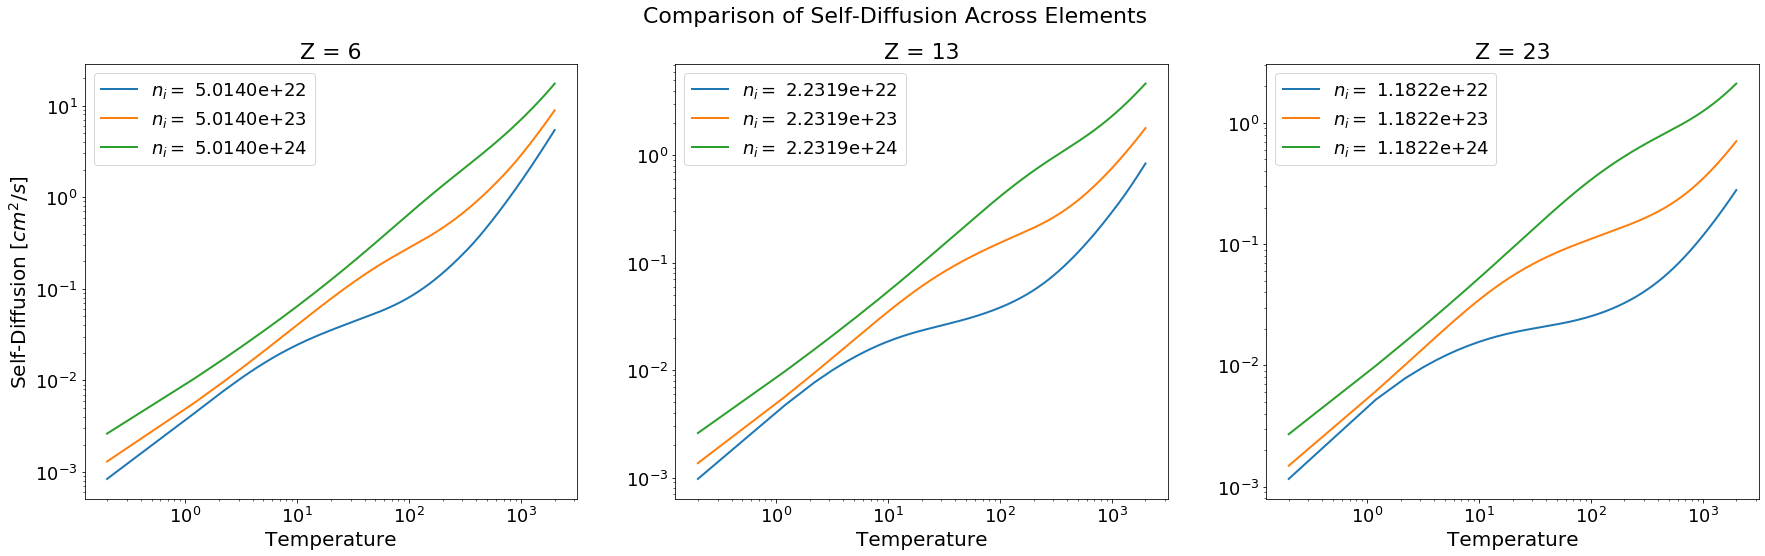

In [249]:
# Multiple elements, multiple mass densities, single temperature - sm.plot test

Am = np.array([1.9944235e-23, 4.4803895e-23, 8.4590343e-23]) # atomic mass of carbon-12 [g]
rho_i = np.array([1,10,100]) # mass density [g/cc]
T = np.arange(0.2, 2000, 1) # temeprature [eV]
Z = np.array([6, 13, 23]) # atomic number of carbon

# Instantiate the stanton-murillo transport class
sm = sm_transport(Am, rho_i, T, Z, units_out='cgs')

# Compute transport 
D = sm.self_diffusion()
eta = sm.viscocity()
K = sm.thermal_conductivity()

# print('Self-diffusion:', D)
# print('\nViscosity:', eta)
# print('\nThermal Conductivity:', K)

print(np.shape(D), np.shape(eta), np.shape(K))

fig, ax = sm.plot(T, eta, xaxis='temperature')
ax[0].set_ylabel('Self-Diffusion $[cm^2/s]$', fontsize=20)
fig.suptitle('Comparison of Self-Diffusion Across Elements', fontsize=22)
plt.savefig('self-diffusion_test.png', dpi=300, bbox_inches='tight')